## Test Configuration
| Duct Configuration  | Propeller Type       | Measured Propeller Diameter | Propeller Tip Profile | Duct Inner Diameter | Lip Configuration |
| --------------------|----------------------|-----------------------------|-----------------------|---------------------| ------------------|
| Open air / unducted | HQ Prop 5" Hex Blade |                             | Original / Unshaved   | N/A                 | None              |

## Procedure
Initiate throttle sweep from 0-100% throttle in increments of 5%, holding each step for 5 seconds. For each aerodynamic configuration, disassemble and reassemble between tests to ensure repeatability.

## Hypothesis
We expect the low blade count and low pitch propellers to be more power efficient, but produce less thrust.

## Impact
The results from this test will determine the props used in the rest of our testing. Props that produce significantly less thrust than required to lift a payload (~12 N) will be eliminated and a propeller with high power efficiency around the 12 N range will be selected, with slight preference toward high efficiency in the 8 N range (flight without payload) and high full throttle thrust.

This test will also validate full throttle performance of our motors. Another possible outcome of this test is that the low-KV motors do not spin our propellers fast enough to produce enough thrust for flight with a payload. If so, new motors will need to be purchased and these tests will have to be rerun with those motors, as both motors and propellers contribute to power efficiency.

## Analysis
Average battery voltage, motor currents, and thrust will be collected for each throttle step after the transients stabilize, and a thrust vs. electrical power plot will be made to compare all props.

## Observations

For our first few full throttle tests, we noticed our thrust start to decrease as throttle went above about 75%, the root cause of this was determined to be the movable carriage hitting the end stops, which were taking up some of the load since the jig was remounted to a new base and the relative positioning of components changed since the last test.

In [1]:
from runner import test_run, TestPlan, TestStep
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv

### Specify Test Plan
Initialize a test plan object which sweeps from 0 to 100% throttle in increments of 5%, holding at each step for 2 seconds

In [2]:
# 1. Create a test plan consisting of steps.
step_duration_ms = 2_000
step_range = np.arange(5, 101, 5)
steps = [
    TestStep(bottom_throttle=i, top_throttle=i, duration_ms=step_duration_ms)
    for i in step_range
]
plan = TestPlan("test", steps=steps)
plan

TestPlan(name='test', steps=[TestStep(duration_ms=2000, top_throttle=5, bottom_throttle=5, pitch_angle=None, roll_angle=None), TestStep(duration_ms=2000, top_throttle=10, bottom_throttle=10, pitch_angle=None, roll_angle=None), TestStep(duration_ms=2000, top_throttle=15, bottom_throttle=15, pitch_angle=None, roll_angle=None), TestStep(duration_ms=2000, top_throttle=20, bottom_throttle=20, pitch_angle=None, roll_angle=None), TestStep(duration_ms=2000, top_throttle=25, bottom_throttle=25, pitch_angle=None, roll_angle=None), TestStep(duration_ms=2000, top_throttle=30, bottom_throttle=30, pitch_angle=None, roll_angle=None), TestStep(duration_ms=2000, top_throttle=35, bottom_throttle=35, pitch_angle=None, roll_angle=None), TestStep(duration_ms=2000, top_throttle=40, bottom_throttle=40, pitch_angle=None, roll_angle=None), TestStep(duration_ms=2000, top_throttle=45, bottom_throttle=45, pitch_angle=None, roll_angle=None), TestStep(duration_ms=2000, top_throttle=50, bottom_throttle=50, pitch_ang

### Execute Tests

In [3]:
test_directory = "../test_data/open_air/"
test_filename = "two_cells_upto100_endstop_fixed"
test_filepath = (Path(test_directory) / test_filename).with_suffix(".csv")

In [4]:
# 2. Connect to jig and run the test.
test_data = test_run(filename=test_filepath, plan=plan)

Loading saved data


### Data Analysis

Clear new lines from saved csv's, not always necessary but this will not affect a properly formatted file.

In [5]:
# Extract raw data from a loaded test csv
top_current_raw = test_data["top_current_A"]
bottom_current_raw = test_data["bottom_current_A"]
hall_current_raw = top_current_raw + bottom_current_raw

shunt_current_raw = test_data["batt_current_A"]
batt_voltage = test_data["batt_voltage_V"]

top_rpm = test_data["top_motor_rpm"]
bottom_rpm = test_data["bottom_motor_rpm"]

thrust_N = test_data["thrust_N"]
time_ms = test_data.index

In [6]:
# Determine mean sample rate
sample_rate_ms = np.mean(np.diff(time_ms))

# Generate buckets for averaging based on step duration defined in testing
stable_step_duration_ms = step_duration_ms / 2
transient_offset_ms = (
    500  # Ignore first 500 ms of each throttle step to allow transients to settle
)

# Aggregate data for each throttle step
step_start_times = np.arange(len(step_range)) * step_duration_ms
df_steps = (
    pd.concat(
        [
            test_data.loc[
                t_start
                + transient_offset_ms : t_start
                + transient_offset_ms
                + stable_step_duration_ms
            ]
            for t_start in step_start_times
        ],
        keys=step_range,
        names=["throttle"],
    )
    .groupby("throttle")
    .mean()
)

In [7]:
thrust_mean_g = df_steps["thrust_N"] / 9.81 * 1e3
thrust_mean_g = thrust_mean_g * (thrust_mean_g > 0)
hover_thrust_g = 750
payload_thrust_g = 1200

hall_current_mean = df_steps["top_current_A"] + df_steps["bottom_current_A"]
batt_voltage_mean = df_steps["batt_voltage_V"]
batt_power_mean = hall_current_mean * batt_voltage_mean

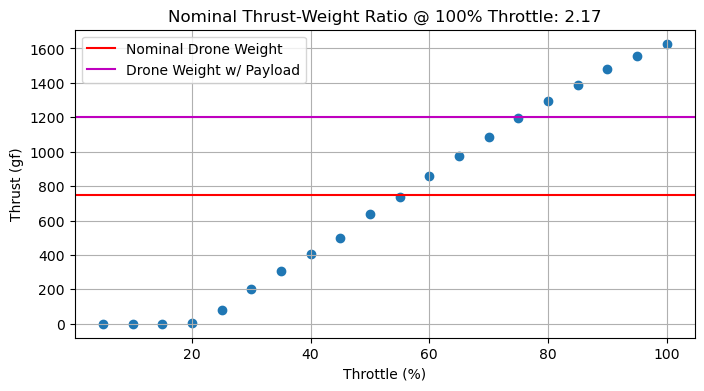

In [8]:
plt.figure(figsize=(8, 4))
plt.xlabel("Throttle (%)")
plt.ylabel("Thrust (gf)")
plt.scatter(step_range, thrust_mean_g)
plt.axhline(hover_thrust_g, color="r", label="Nominal Drone Weight")
plt.axhline(payload_thrust_g, color="m", label="Drone Weight w/ Payload")
plt.title(
    "Nominal Thrust-Weight Ratio @ 100% Throttle: "
    + f"{(thrust_mean_g.iloc[-1] / hover_thrust_g):.2f}"
)
plt.legend()
plt.grid()
plt.show()

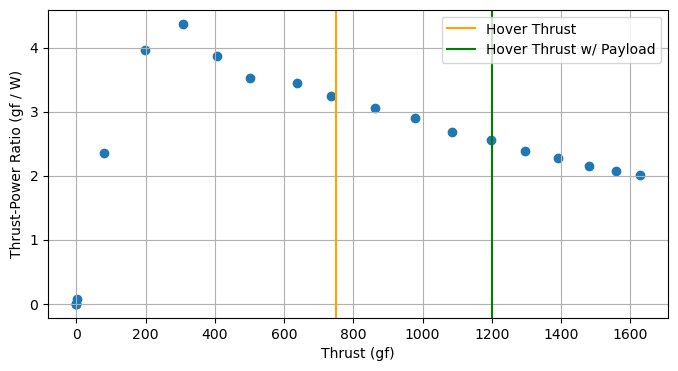

In [9]:
plt.figure(figsize=(8, 4))
plt.xlabel("Thrust (gf)")
plt.ylabel("Thrust-Power Ratio (gf / W)")
plt.axvline(hover_thrust_g, color="orange", label="Hover Thrust")
plt.axvline(payload_thrust_g, color="g", label="Hover Thrust w/ Payload")
plt.scatter(thrust_mean_g, thrust_mean_g / batt_power_mean)
plt.grid()
plt.legend()
plt.show()

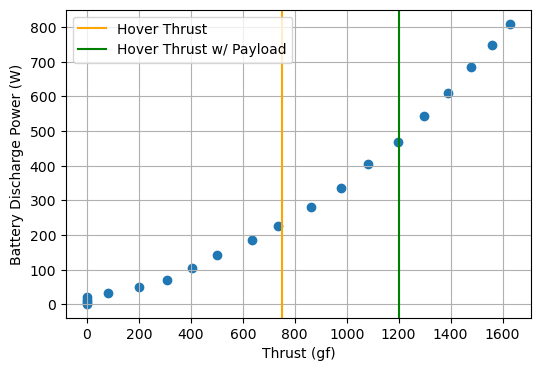

In [10]:
plt.figure(figsize=(6, 4))
plt.scatter(thrust_mean_g, batt_power_mean)
plt.grid()
plt.xlabel("Thrust (gf)")
plt.ylabel("Battery Discharge Power (W)")
plt.axvline(hover_thrust_g, color="orange", label="Hover Thrust")
plt.axvline(payload_thrust_g, color="g", label="Hover Thrust w/ Payload")
plt.legend()
plt.show()